<a href="https://colab.research.google.com/github/chinedu01/GDPR-Transparency-and-Consent-Framework/blob/master/Copy_of_Copy_of_Copy_of_Toxic_Comment_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the enviroment

In [ ]:
#installing kaggle
! pip install kaggle

In [ ]:
#Mount Google Drive
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"chineduabonyi","key":"7931bc8b20a6f4709eaffa70fe928bdb"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#create a kaggle folder
! cp kaggle.json ~/.kaggle/
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

#Grant permission to the Json file 
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#Download dataset
! kaggle competitions download jigsaw-toxic-comment-classification-challenge

#Unzip files
! unzip jigsaw-toxic-comment-classification-challenge.zip
! unzip sample_submission.csv.zip
! unzip test.csv.zip
! unzip test_labels.csv.zip
! unzip train.csv.zip


 80% 42.0M/52.6M [00:00<00:00, 89.5MB/s]
100% 52.6M/52.6M [00:00<00:00, 90.2MB/s]
Archive:  jigsaw-toxic-comment-classification-challenge.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  train.csv.zip
  inflating: train.csv               


# Import Required Library

In [ ]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re 
import zipfile
import string
import nltk
nltk.download('stopwords')
import string
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer() 
import spacy.cli
from sklearn.model_selection import GridSearchCV
nltk.download('punkt')
nltk.download('stopwords')
spacy.cli.download("en_core_web_lg")
nlp = spacy.load('en_core_web_lg')
!python -m spacy download en_core_web_lg
from nltk.stem.snowball import SnowballStemmer
from gensim.models import word2vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns
from gensim.models import Word2Vec

# Data Exploration

In [ ]:
#Reading the Dataset
training_dataframe = pd.read_csv('train.csv')
testing_dataframe = pd.read_csv('test.csv')
submission_dataframe = pd.read_csv('sample_submission.csv')

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#submission_dataframe = pd.DataFrame()
#submission['id'] = df_sub.id.copy()

#Exploring the Dataset
training_dataframe.info()
training_dataframe.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
#Checking for missing values
training_dataframe.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
#Previewing the comments
for i in range(6):
    print(training_dataframe['comment_text'][i])
    print('---------------')

Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
---------------
D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
---------------
Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
---------------
"
More
I can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any prefere

"rects = ax.patches\nlabels = data_raw.iloc[:,2:].sum().values\nfor rect, label in zip(rects, labels):\n    height = rect.get_height()\n    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)\nplt.show()\n"

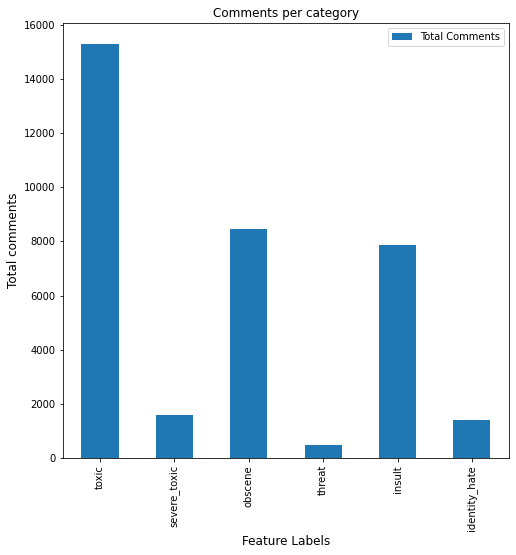

In [ ]:
# Removed unnecessary columns - "id" and "comment_text"
y_feature = training_dataframe.drop(['id', 'comment_text'], axis=1)    

# A list that contains tuple which consists of class label and number of comments for that particular class 
counts = []                                               
categories = list(y_feature.columns.values)
for i in categories:
    counts.append((i, y_feature[i].sum()))

# Dataframe made up of category and total number of comments   
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments']) 
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)

"""rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)
plt.show()
"""

Text(0.5, 0, 'Feature Labels')

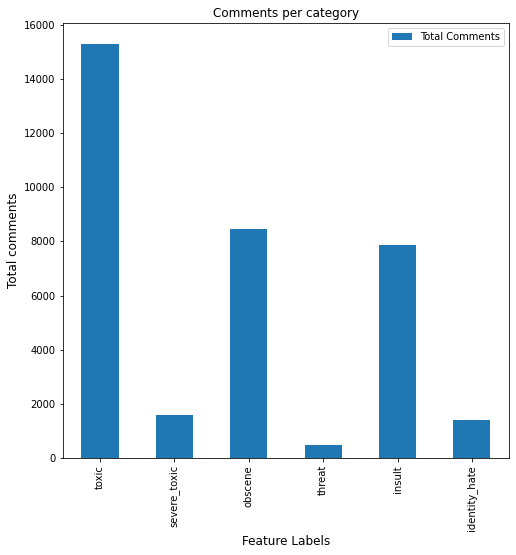

In [ ]:
# Removed unnecessary columns - "id" and "comment_text"
y_feature = training_dataframe.drop(['id', 'comment_text'], axis=1)    

# A list that contains tuple which consists of class label and number of comments for that particular class 
counts = []                                               
categories = list(y_feature.columns.values)
for i in categories:
    counts.append((i, y_feature[i].sum()))

# Dataframe made up of category and total number of comments   
df_1 = pd.DataFrame(counts, columns=['Feature Labels', 'Total Comments']) 
df_1.plot(x='Feature Labels', y='Total Comments', kind='bar',figsize=(8,8))
plt.title("Comments per category")
plt.ylabel('Total comments', fontsize=12)
plt.xlabel('Feature Labels', fontsize=12)



In [ ]:
for i in list(y_feature.columns):
    print("Percent of {0}s: ".format(i), round(100*y_feature[i].mean(),2), "%")

Percent of toxics:  9.58 %
Percent of severe_toxics:  1.0 %
Percent of obscenes:  5.29 %
Percent of threats:  0.3 %
Percent of insults:  4.94 %
Percent of identity_hates:  0.88 %


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


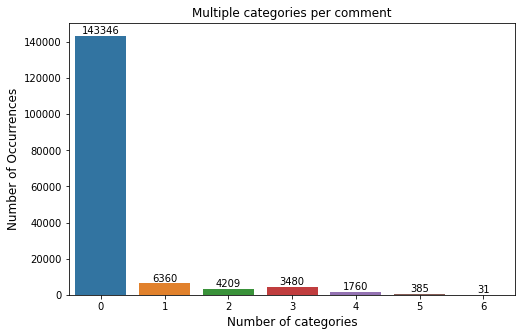

In [ ]:
sums_of_rows = training_dataframe.iloc[:,2:].sum(axis=1)
x=sums_of_rows.value_counts()

#plotting of the chart
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of categories', fontsize=12)

#including the 
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()


#Source: Adapted from https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

In [ ]:
"""print('Percentage of comments that are not labelled:')
print(len(training_dataframe[(training_dataframe['toxic']==0) & (training_dataframe['severe_toxic']==0) & (training_dataframe['obscene']==0) & (training_dataframe['threat']== 0) & (training_dataframe['insult']==0) & (training_dataframe['identity_hate']==0)]) / len(training_dataframe)"""


"print('Percentage of comments that are not labelled:')\nprint(len(training_dataframe[(training_dataframe['toxic']==0) & (training_dataframe['severe_toxic']==0) & (training_dataframe['obscene']==0) & (training_dataframe['threat']== 0) & (training_dataframe['insult']==0) & (training_dataframe['identity_hate']==0)]) / len(training_dataframe)"

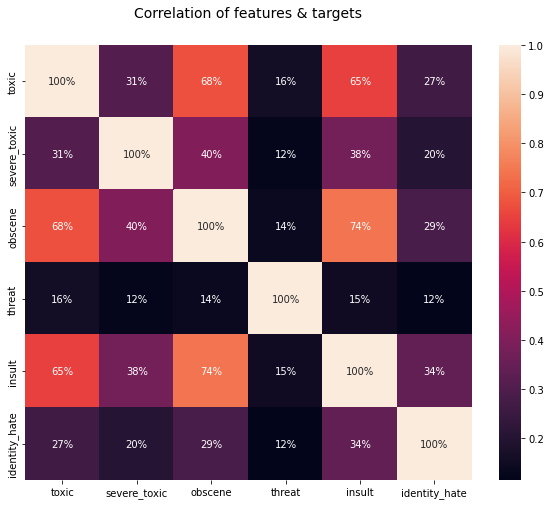

In [ ]:
import seaborn as sns
plt.figure(figsize=(10,8)) 
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(y_feature.corr(), annot =True, fmt='.0%')

In [ ]:
#Statisical analysis of the text.
length = training_dataframe['comment_text'].str.len()

print("Max length of a string is {}".format(length.max()))
print("Mean length of a string is {}".format(length.mean()))
print("Minimum length of a string is {}".format(length.min()))

Max length of a string is 5000
Mean length of a string is 394.0732213246768
Minimum length of a string is 6


In [ ]:
#Determining the percentage of unlabelled comments.
unlabelled_comments = training_dataframe[
                      (training_dataframe['toxic']!=1) & 
                      (training_dataframe['severe_toxic']!=1) &
                      (training_dataframe['obscene']!=1) & 
                      (training_dataframe['threat']!=1) &
                      (training_dataframe['insult']!=1) &
                      (training_dataframe['identity_hate']!=1)
                                          ]
answer = len(unlabelled_comments)/len(training_dataframe)*100

print('Percentage of unlabelled comments is ', answer)



Percentage of unlabelled comments is  89.83211235124176


In [ ]:
target = training_dataframe[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
target.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [ ]:
"""target.sum(axis=0) / target.shape[0]
for i in list(comments.columns):
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")"""

'target.sum(axis=0) / target.shape[0]\nfor i in list(comments.columns):\n    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")'

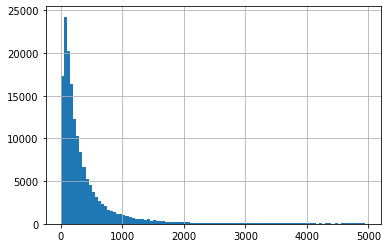

In [ ]:
#Distribution of lenght of comment text
lens = training_dataframe.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))


#Data Preprocessing

In [ ]:
stopwords_ = stopwords.words('english')
stopwords_[:12]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll"]

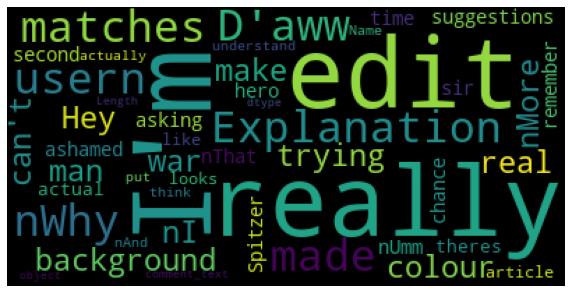

In [ ]:
#Using a word cloud find the top 50 words by frequency among all the review texts
!pip install wordcloud
from wordcloud import WordCloud

wordcloud = WordCloud(stopwords=stopwords_,max_words=50).generate(str(training_dataframe.comment_text))
#comments = train_df['comment_text'].loc[train_df['toxic']==0].values
print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [ ]:
#Data cleaner
def simple_clear(text):
    text = text.lower()
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = re.sub('<.*?>','',text)
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)
    text = re.sub('\[|\(.*\]|\)','', text) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)  
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    
    return text

In [ ]:
#Data Cleaning
training_dataframe['cleaned_comment_text'] = training_dataframe['comment_text'].apply(simple_clear)
training_dataframe['cleaned_comment_text']

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i m se...
2         hey man i m really not trying to edit war it s...
3          more i can t make any real suggestions on imp...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566     and for the second time of asking when your v...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570     and i really don t think you understand i cam...
Name: cleaned_comment_text, Length: 159571, dtype: object

In [ ]:
training_dataframe['len'] = training_dataframe['comment_text'].str.len()
print('Average comment length: %d' % training_dataframe['len'].mean())
print('Median comment length: %d' % training_dataframe['len'].quantile(.5))
print('90th percentile comment length: %d' % training_dataframe['len'].quantile(.9))



Average comment length: 394
Median comment length: 205
90th percentile comment length: 889


In [ ]:
#lemmatization
stemmer = SnowballStemmer(language='english')
stopwords = nlp.Defaults.stop_words
def apply_stemmer(text):
    words = text.split()
    sent = [snow_stemmer.stem(word) for word in words if not word in set(stopwords)]
    return ' '.join(sent)

In [ ]:
#Splitting of Dataset into Training and Test Datasets
X_cleaned = training_dataframe['cleaned_comment_text']
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_feature, test_size=0.2, random_state=42,shuffle = True)

In [ ]:
#TF-IDF
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',                 
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 1),         
    stop_words = stopwords_,
    sublinear_tf=True)

word_vectorizer.fit(X_train)

In [ ]:
#Word Embedding
#embeddings_dict = {}


In [ ]:
X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords.words("english")


#Model Training: Logistic Regression (TF-IDF)

In [ ]:
#GridSearchCV for Logistic Regressing utlizing Pipeline 
pipe_Log_reg =  Pipeline([("Log_reg", LogisticRegression(random_state = 42,max_iter = 10000))])
params = {'Log_reg__penalty': ['l2'],
          'Log_reg__C': [0.5,0.75,1],
          'Log_reg__class_weight': ['balanced',None],
          'Log_reg__solver': ['liblinear']}
Log_reg = GridSearchCV(pipe_Log_reg,params,scoring='roc_auc',return_train_score=True,n_jobs=-1)
Log_reg.fit(X_train_transformed,y_train.toxic)
print(f'Best_score = {Log_reg.best_score_}')
print(f'Best_params = {Log_reg.best_params_}')
print(f'Roc_auc at test:  = {roc_auc_score(y_test.toxic,Log_reg.predict(X_test_transformed))}')

In [ ]:
# Utilizing the best parameters provide by GridsearchCV
from sklearn.multiclass import OneVsRestClassifier
log_reg = LogisticRegression(C = 1, penalty='l2', solver = 'liblinear',class_weight = 'balanced', random_state=42)

#
classifier_ovr_log = OneVsRestClassifier(log_reg)
classifier_ovr_log.fit(X_train_transformed, y_train)
y_test_proba_prediction = classifier_ovr_log.predict_proba(X_test_transformed)
y_train_proba_prediction = classifier_ovr_log.predict_proba(X_train_transformed)

In [ ]:
print("ROC AUC Score Test:", roc_auc_score(y_test, classifier_ovr_log.predict(X_test_transformed)))
print(classification_report(y_test, classifier_ovr_log.predict(X_test_transformed)))

In [ ]:

y_test_proba_prediction

In [ ]:
def make_test_predictions(training_dataframe,classifier):
    training_dataframe.comment_text =training_dataframe.comment_text.astype(str)
    training_dataframe.comment_text = training_dataframe.comment_text.apply(simple_clear)
    training_dataframe.comment_text = training_dataframe.comment_text.apply(apply_stemmer)
    X_test = training_dataframe.comment_text
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    y_test_pred_training_dataframe = pd.DataFrame(y_test_pred,columns=categories.columns)
    submission_training_dataframe = pd.concat([training_dataframe.id, y_test_pred_training_dataframe], axis=1)
    submission_training_dataframe.to_csv('submission.csv', index = False)



#Model Training: Support Vector Machine - (TF-IDF)

In [ ]:
pipe_SVC =  Pipeline([("SVC", LinearSVC(max_iter = 10000,random_state = 42))])
params = {'SVC__penalty': ['l2','l1'],
           'SVC__C': [0.1,0.2,0.3],
          'SVC__class_weight': ['balanced',None]}
SVC_ = GridSearchCV(pipe_SVC,params,scoring='f1',return_train_score=True,n_jobs=-1)
SVC_.fit(X_train_transformed,y_train.toxic)
print(f'The Best score is = {SVC_.best_score_}')
print(f'The Best parameters = {SVC_.best_params_}')
print(f'The ROC_AUC at test is:  = {roc_auc_score(y_test.toxic,SVC_.predict(X_test_transformed))}')

In [ ]:
SVC_auc = LinearSVC(C = 0.2,class_weight = 'balanced',max_iter = 10000, random_state=42)

classifier_ovr_SVC_auc = OneVsRestClassifier(SVC_auc)
classifier_ovr_SVC_auc.fit(X_train_transformed, y_train)

#Model Training: Naive Bayes (TF-IDF)

In [ ]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, y_train)
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(y_test, prediction)))

# Tokenizing and Padding


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence

max_features=20000
max_text_length=400

x=training_dataframe['cleaned_comment_text'].values


x_tokenizer=text.Tokenizer(max_features, oov_token=True)
x_tokenizer.fit_on_texts(list(x))
x_tokenized=x_tokenizer.texts_to_sequences(x)
x_train_val=sequence.pad_sequences(x_tokenized,maxlen=max_text_length)

In [ ]:
print(x_tokenized)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
x_train_val



array([[    0,     0,     0, ...,    69,  3226,    90],
       [    0,     0,     0, ...,    38,   944,   183],
       [    0,     0,     0, ...,     1,   710,   462],
       ...,
       [    0,     0,     0, ...,  3297, 12699,  4181],
       [    0,     0,     0, ...,   154,    36,    10],
       [    0,     0,     0, ...,  1563,  1966,    89]], dtype=int32)

In [ ]:
#nltk tokenizing
from nltk.tokenize import word_tokenize
